Modified from polychrom extrusion_1D_newCode\
Original Source : https://github.com/open2c/polychrom.git \
Licensed under MIT License\
Copyright (c) 2019 Massachusetts Institute of Technology

In [1]:
#From Polychrom

import numpy as np
import pandas as pd
import h5py 

class leg(object):
    def __init__(self, pos, attrs={"stalled":False, "CTCF":False}):
        """
        A leg has two important attribues: pos (positions) and attrs (a custom list of attributes)
        """
        self.pos = pos
        self.attrs = dict(attrs)

class cohesin(object):
    """
    A cohesin class provides fast access to attributes and positions 
    
    
    cohesin.left is a left leg of cohesin, cohesin.right is a right leg
    cohesin[-1] is also a left leg and cohesin[1] is a right leg         
    
    Also, cohesin.any("myattr") is True if myattr==True in at least one leg
    cohesin.all("myattr") is if myattr=True in both legs
    """
    def __init__(self, leg1, leg2):
        self.left = leg1
        self.right = leg2
   
    def any(self, attr):
        return self.left.attrs[attr] or self.right.attrs[attr]
    
    def all(self, attr):
        return self.left.attrs[attr] and self.right.attrs[attr]    
    
    def __getitem__(self, item):
        if item == -1:
            return self.left
        elif item == 1:
            return self.right 
        else:
            raise ValueError()
        

def unloadProb(cohesin, args):
    """
    Defines unload probability based on a state of cohesin 
    """
    if cohesin.any("stalled"):
        # if one side is stalled, we have different unloading probability 
        # Note that here we define stalled cohesins as those stalled not at CTCFs 
        return 1 / args["LIFETIME_STALLED"]
    # otherwise we are just simply unloading 
    return 1 / args["LIFETIME"]    
    


def loadOne(cohesins, occupied, args): 
    """
    A function to load one cohesin 
    """
    while True:
        a = np.random.randint(args["N"])
        if (occupied[a] == 0) and (occupied[a+1] == 0):
            occupied[a] = 1
            occupied[a+1] = 1 
            cohesins.append(cohesin(leg(a), leg(a+1)))
            break


def capture(cohesin, occupied, args):
    """
    We are describing CTCF capture here. 
    This function is specific to this particular project, and 
    users are encouraged to write functions like this 
    
    Note the for-loop over left/right sites below, and using cohesin[side] 
    to get left/right leg. 
    
    Also note how I made ctcfCapture a dict with -1 coding for left side, and 1 for right side 
    and ctcfCapture are dicts as well: keys are locations, and values are probabilities of capture
    """    
    for side in [1, -1]:
        # get probability of capture or otherwise it is 0 
        if np.random.random() < args["ctcfCapture"][side].get(cohesin[side].pos, 0):  
            cohesin[side].attrs["CTCF"] = True  # captured a cohesin at CTCF     
    return cohesin 


def release(cohesin, occupied, args):
    
    """
    AN opposite to capture - releasing cohesins from CTCF 
    """
    
    if not cohesin.any("CTCF"):
        return cohesin  # no CTCF: no release necessary 
        
    # attempting to release either side 
    for side in [-1, 1]: 
        if (np.random.random() < args["ctcfRelease"][side].get(cohesin[side].pos, 0)) and (cohesin[side].attrs["CTCF"]):
            cohesin[side].attrs["CTCF"] = False 
    return cohesin 


def translocate(cohesins, occupied, args):
    """
    This function describes everything that happens with cohesins - 
    loading/unloading them and stalling against each other 
    
    It relies on the functions defined above: unload probability, capture/release. 
    """
    # first we try to unload cohesins and free the matching occupied sites 
    for i in range(len(cohesins)):
        prob = unloadProb(cohesins[i], args)
        if np.random.random() < prob:
            occupied[cohesins[i].left.pos] = 0 
            occupied[cohesins[i].right.pos] = 0 
            del cohesins[i]
            loadOne(cohesins, occupied, args)
    
    # then we try to capture and release them by CTCF sites 
    for i in range(len(cohesins)):
        cohesins[i] = capture(cohesins[i], occupied, args)
        cohesins[i] = release(cohesins[i], occupied, args)
    
    # finally we translocate, and mark stalled cohesins because 
    # the unloadProb needs this 
    for i in range(len(cohesins)):
        cohesin = cohesins[i] 
        for leg in [-1,1]: 
            if not cohesin[leg].attrs["CTCF"]: 
                # cohesins that are not at CTCFs and cannot move are labeled as stalled 
                if occupied[cohesin[leg].pos  + leg] != 0:
                    cohesin[leg].attrs["stalled"] = True
                else:
                    cohesin[leg].attrs["stalled"] = False 
                    occupied[cohesin[leg].pos] = 0
                    occupied[cohesin[leg].pos + leg] = 1
                    cohesin[leg].pos += leg        
        cohesins[i] = cohesin
        
def color(cohesins, args):
    "A helper function that converts a list of cohesins to an array colored by cohesin state"    
    def state(attrs):
        if attrs["stalled"]:
            return 2
        if attrs["CTCF"]:
            return 3
        return 1
    ar = np.zeros(args["N"])
    for i in cohesins:
        ar[i.left.pos] = state(i.left.attrs)
        ar[i.right.pos] = state(i.right.attrs)  
    return ar 

In [2]:
import os 
if not os.path.exists("trajectory"):
    os.mkdir("trajectory")

In [20]:
N1 = 500 # size of one system ~ length of a polymer
M = 10 # 10 independent replicates
N = N1 * M 

LIFETIME = 200 
SEPARATION = 200
LEFNum = N // SEPARATION 
trajectoryLength = 10000

args = {}

In [21]:
ctcfLeftCapture = {50 + k*N1: 0.5 for k in range(M)} #4000 monomer, 50 and 150 CTCF
ctcfRightCapture = {150 + k*N1: 0.5 for k in range(M)}
ctcfLeftRelease = {50:0.02}     # and we release them with 0.02 probability each step (on average 50 step residence time)
ctcfRightRelease = {150:0.02}  

args["ctcfRelease"] = {-1:ctcfLeftRelease, 1:ctcfRightRelease}  # this is how we feed the dictionaries of capture/release probabilities to our code 
args["ctcfCapture"] = {-1:ctcfLeftCapture, 1:ctcfRightCapture}        
args["N"] = N 
args["LIFETIME"] = 100
args["LIFETIME_STALLED"] = 10

In [22]:
occupied = np.zeros(N)
for k in range(M):
    occupied[k*N1] = 1
    occupied[(k+1)*N1 - 1] = 1
cohesins = []

for i in range(LEFNum):
    loadOne(cohesins,occupied, args)

with h5py.File("trajectory/LEFPositions.h5", mode='w') as myfile:
    
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), 
                                 dtype=np.int32, 
                                 compression="gzip")
    steps = 50    # saving in 50 chunks because the whole trajectory may be large 
    bins = np.linspace(0, trajectoryLength, steps, dtype=int) # chunks boundaries 
    for st,end in zip(bins[:-1], bins[1:]):
        cur = []
        for i in range(st, end):
            translocate(cohesins, occupied, args)  # actual step of LEF dynamics 
            positions = [(cohesin.left.pos, cohesin.right.pos) for cohesin in cohesins]
            cur.append(positions)  # appending current positions to an array 
        cur = np.array(cur)  # when we finished a block of positions, save it to HDF5 
        dset[st:end] = cur
    myfile.attrs["N"] = N
    myfile.attrs["LEFNum"] = LEFNum

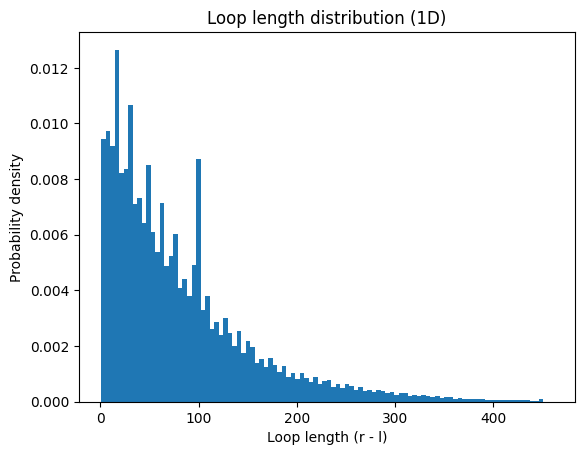

In [23]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File("trajectory/LEFPositions.h5", "r") as f:
    positions = f["positions"][:]

loop_lengths = positions[:,:,1] - positions[:,:,0]
loop_lengths = loop_lengths.flatten()

plt.hist(loop_lengths, bins=100, density=True)
plt.xlabel("Loop length (r - l)")
plt.ylabel("Probability density")
plt.title("Loop length distribution (1D)")
plt.show()

#loop length = | r - l |

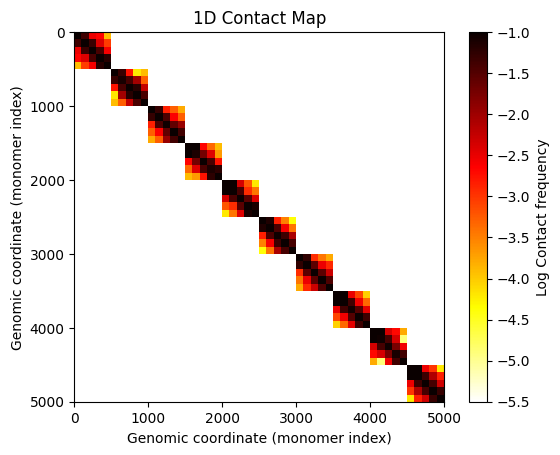

In [44]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

steps = 25
#make the contact map

with h5py.File("trajectory/LEFPositions.h5", "r") as f:
    positions = f["positions"][:]
    N = f.attrs["N"]

cmap = np.zeros((N, N), dtype=np.float32)

for t in range(0, len(positions), steps):
    for l, r in positions[t]:
        cmap[l, r] += 1
        cmap[r, l] += 1
#contact of left & right --> contact! (we somehow ignored the loop between r and l)

#update the Hi-C contact map

cmap /= (len(positions) / steps)

bin_size = 100
Nb = N // bin_size
cmap_binned = cmap.reshape(Nb, bin_size, Nb, bin_size).sum(axis=(1,3))

extent = [0, N, N, 0]

plt.figure()

res = np.log(cmap_binned+1e-6)

plt.imshow(res,
           cmap="hot_r",
           extent=extent,
           vmin = -5.5,
           vmax = -1,)
plt.title("1D Contact Map")
plt.xlabel("Genomic coordinate (monomer index)")
plt.ylabel("Genomic coordinate (monomer index)")
plt.colorbar(label="Log Contact frequency")

plt.show()

Be careful when analyzing the result. This is not a long chromosome, but M independent polymers with length of N1.

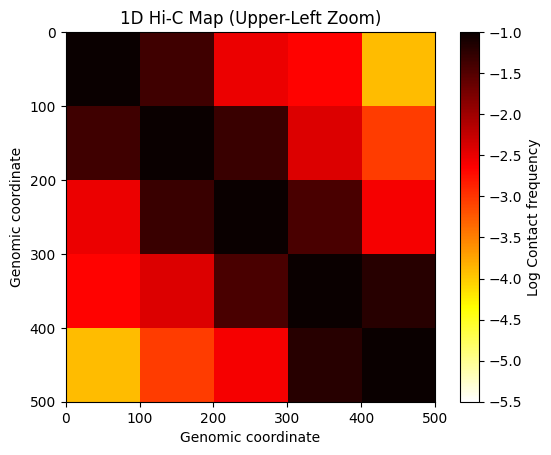

In [51]:
res_sub = res[:int(N1/bin_size), :int(N1/bin_size)]

view_limit_genomic = N1
extent_sub = [0, view_limit_genomic, view_limit_genomic, 0]

plt.figure()

plt.imshow(res_sub,
           cmap="hot_r",
           extent=extent_sub,
           vmin=-5.5,
           vmax=-1)

plt.title("1D Hi-C Map (Upper-Left Zoom)")
plt.xlabel("Genomic coordinate")
plt.ylabel("Genomic coordinate")
plt.colorbar(label="Log Contact frequency")

plt.show()

Due to the binning process, you have to be careful when zooming the TADs!